Examples of visualizations of the logistic model applied to MNIST

## Initial setup

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import data_util
from model_interpretation import viz

def plot(data, labels, s=3, figsize=(7,6)):
    """Plot with segmented colorbar."""
    plt.figure(figsize=figsize)
    plt.scatter(*data.T, s=s, c=labels, cmap='tab10')
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

def get_prob(estimator, data, idx):
    '''Equivalent to estimator.predict_proba(data[idx:idx+1])'''
    logits = (estimator.coef_@data[idx:idx+1].T).T + estimator.intercept_
    probs_calc = scipy.special.softmax(logits)
    return probs_calc

def cross_entropy(estimator, data, labels):
    """Calculate the cross-entropy."""
    logs = estimator.predict_log_proba(data)
    logs_c = -logs[range(len(logs)), labels]

    return logs_c.mean()

# Folder to download the MNIST dataset
root = 'K:/datasets/classification'
# Number of samples to use
n = 5000
# Seed for reproducibility
random.seed(42)

# Load the data and apply PCA
data_train, labels_train, data_valid, labels_valid = data_util.get_mnist_numpy(root, n)

## Testing the quality of 2D projections

### Visualizations of the projections

Three **unsupervised** projection methods are applied to MNIST. The classes are only used when plotting the data.

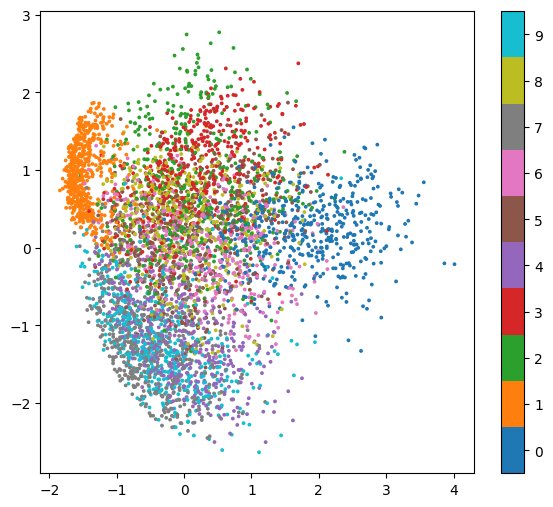

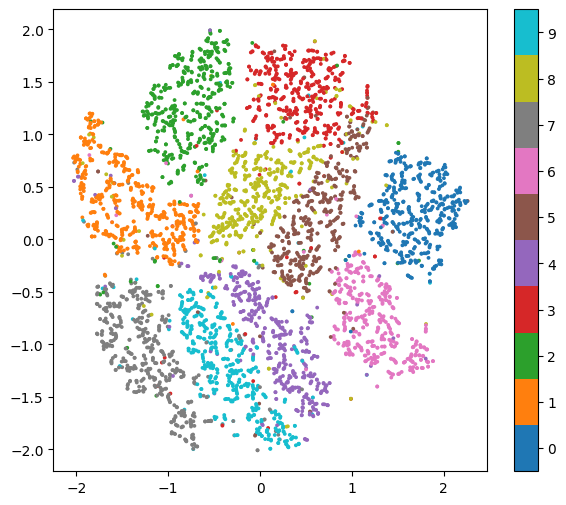

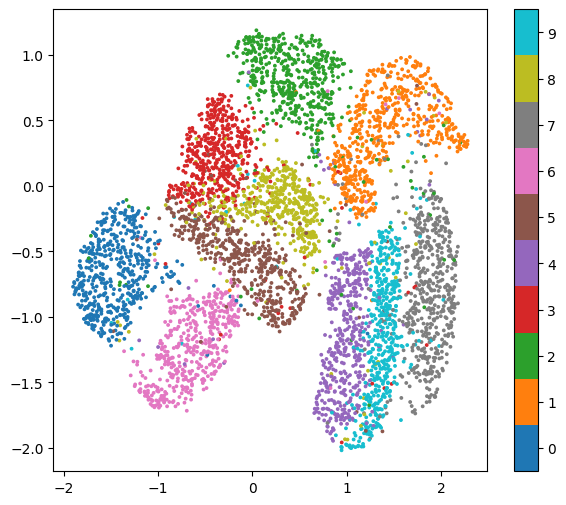

In [3]:
#PCA
mapper = PCA(n_components=2, whiten=True)
proj_pca = mapper.fit_transform(data_train)
plot(proj_pca, labels_train)

#t-SNE
#perplexity: effective number of nearest neighbors
mapper = TSNE(perplexity=7, learning_rate='auto')
proj_tsne = mapper.fit_transform(data_train)
proj_tsne = data_util.normalize(proj_tsne)
plot(proj_tsne, labels_train)

#UMAP
#n_neighbors: number of nearest neighbors
#min_dist: minimum distance
mapper = umap.UMAP(n_neighbors=10, min_dist=0.5)
proj_umap = mapper.fit_transform(data_train)
proj_umap = data_util.normalize(proj_umap)
plot(proj_umap, labels_train)

It is interesting to note that t-SNE and UMAP can successfully cluster the digits in 2D! Remember that these methods are unsupervised.

Next, we fit a logistic regression to the t-SNE data, and plot the decision boundaries:

Accuracy: 89.62
Cross entropy: 0.703837504678786


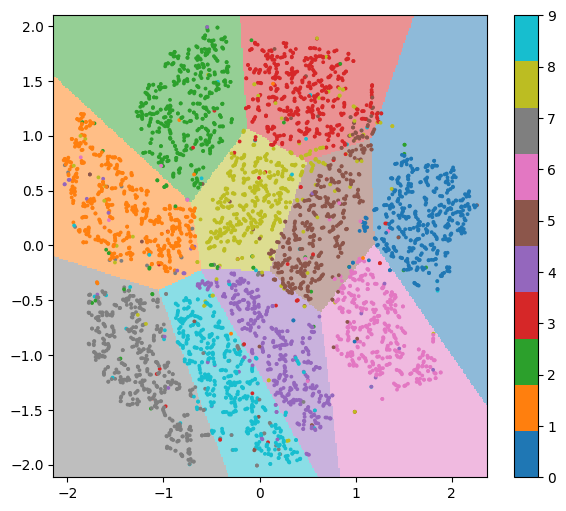

In [4]:
logreg = LogisticRegression(C=1000)
logreg.fit(proj_tsne, labels_train)
print('Accuracy:', 100*logreg.score(proj_tsne, labels_train))
print('Cross entropy:', cross_entropy(logreg, proj_tsne, labels_train))
viz.plot_regions(logreg.predict, proj_tsne, labels_train)

### Plotting class scores

Instead of plotting the decision boundaries, let's plot the class scores (logits) and class probabilities (softmax applied to the scores).

To better understand what the model is doing, we will transform the scikit-learn LogisticRegression class into a simple matrix multiplication for inference, which is exactly what the class does.

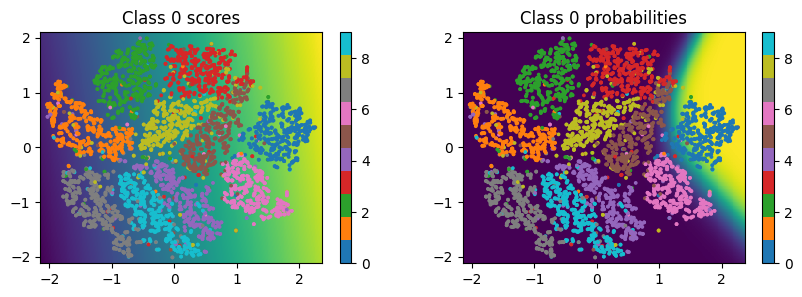

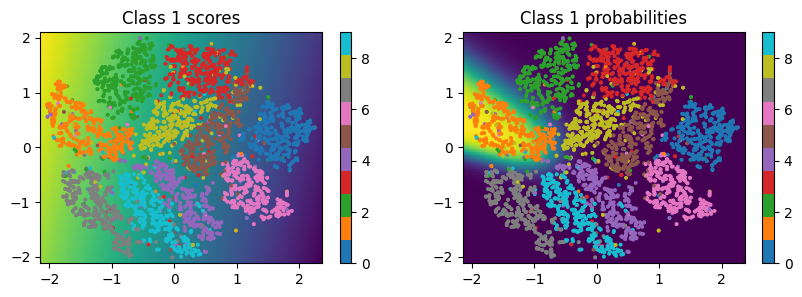

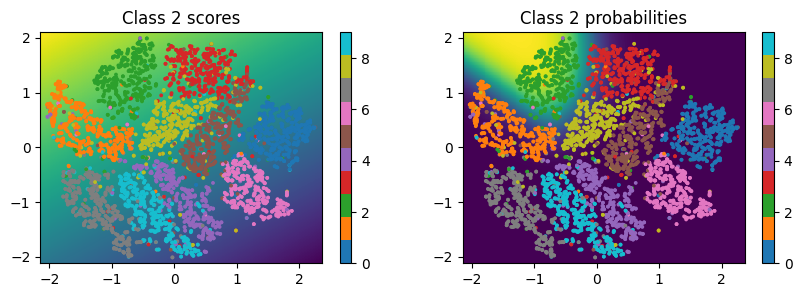

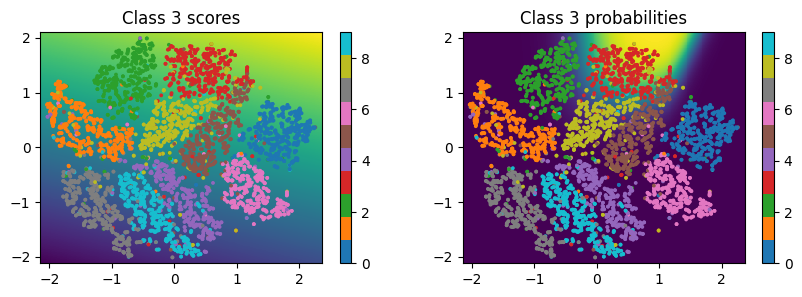

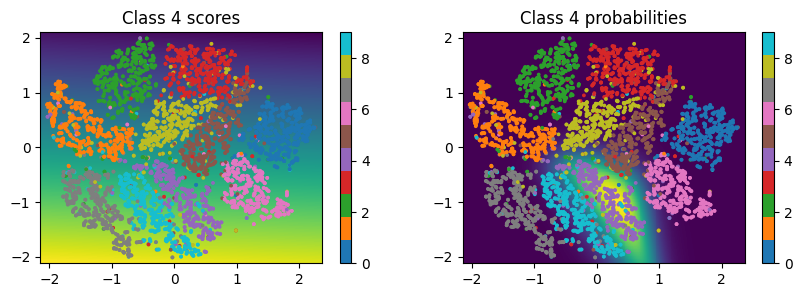

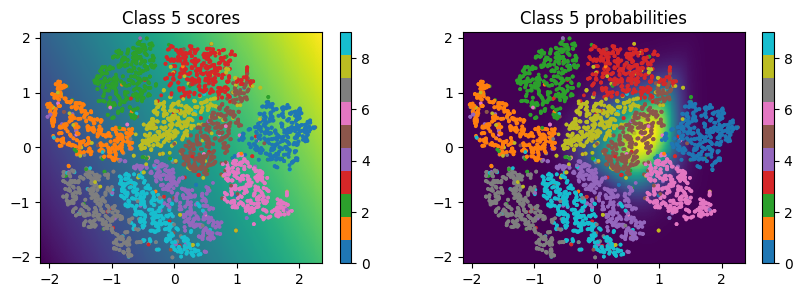

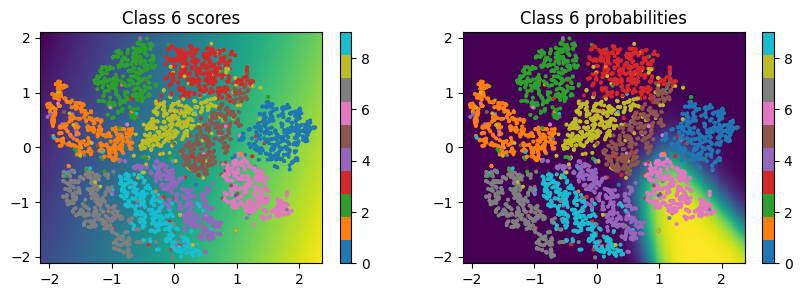

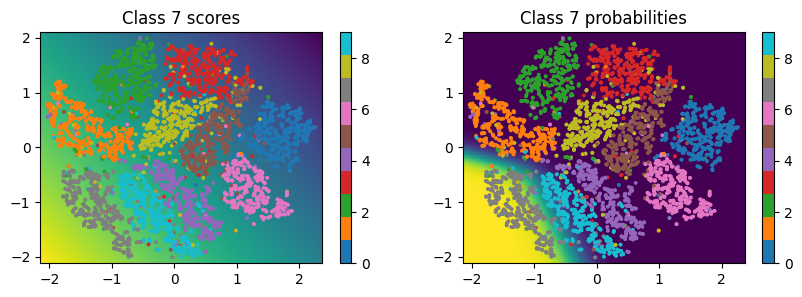

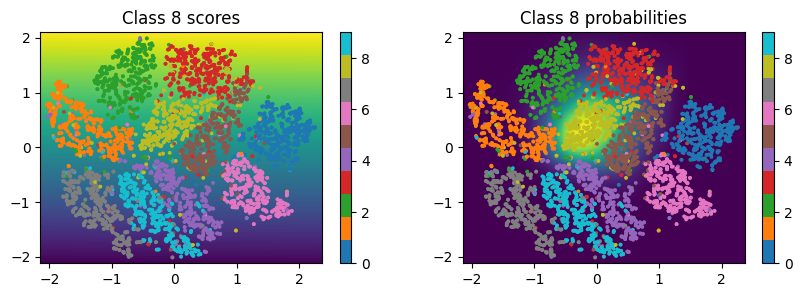

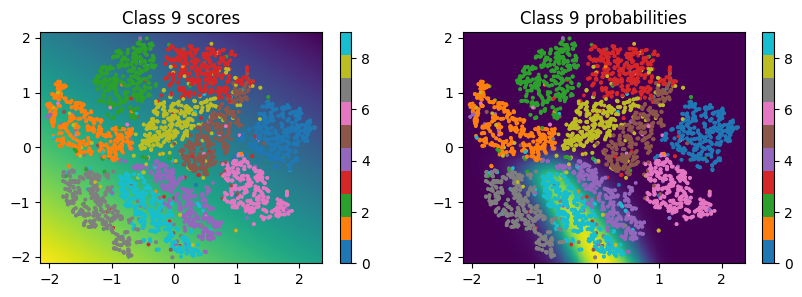

In [6]:
from functools import partial

class Model:
    '''Create a linear model from an instance of the LogisticRegression class.'''

    def __init__(self, logreg):
    
        self.weights = logreg.coef_    # Matrix of coeficients
        self.bias = logreg.intercept_  # Biases

    def __call__(self, x):
        return x@self.weights.T + self.bias
    
def scores(data, model, c):
    """Class scores."""
    logits = model(data)
    return logits[:,c]

def probs(data, model, c):
    """Class probabilities."""
    logits = model(data)
    probs = scipy.special.softmax(logits, axis=1)
    return probs[:,c]

def plot_scores(model, data, labels_train):
    """Given a linear model, create an image with class scores and probabilites."""

    for c in range(10):

        # Function that outputs class scores
        scores_c = partial(scores, model=model, c=c)
        # Function that outputs class probabilites
        probs_c = partial(probs, model=model, c=c)

        response, xx0, xx1 = viz.create_image(scores_c, data)

        fig, axes = plt.subplots(1, 2, figsize=(10,3))
        co = axes[0].pcolormesh(xx0, xx1, response)
        sc = axes[0].scatter(*data.T, s=3, c=labels_train, cmap='tab10')
        fig.colorbar(sc, ax=axes[0])
        axes[0].set_title(f'Class {c} scores')

        response, xx0, xx1 = viz.create_image(probs_c, data)

        co = axes[1].pcolormesh(xx0, xx1, response)
        sc = axes[1].scatter(*data.T, s=3, c=labels_train, cmap='tab10')
        fig.colorbar(sc, ax=axes[1])
        axes[1].set_title(f'Class {c} probabilities')

model = Model(logreg)
plot_scores(model, proj_tsne, labels_train)

Notice that class scores are linear, that is, they are a plane in 3D space, here represented with colors. Since class probabilities are obtained with the softmax function, they are not linear and define a region where the class is most probable.

### Scores and probabilities between class 9 and the others

Let's plot the scores between class 9 and the others. This is roughly equivalent to fitting the logistic model to each pair of classes.

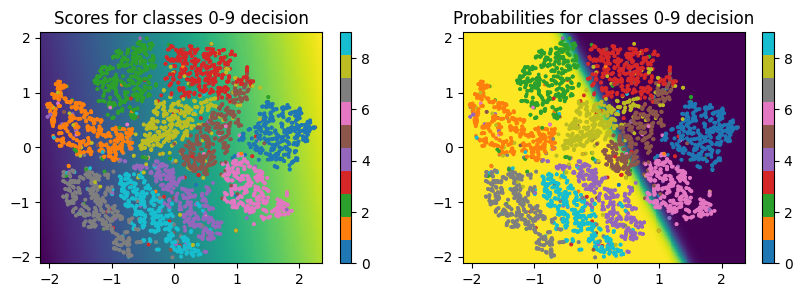

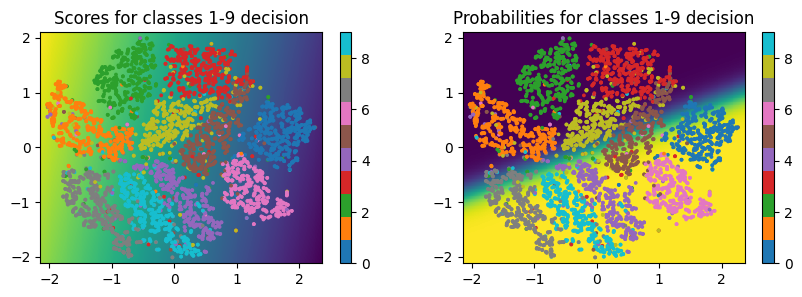

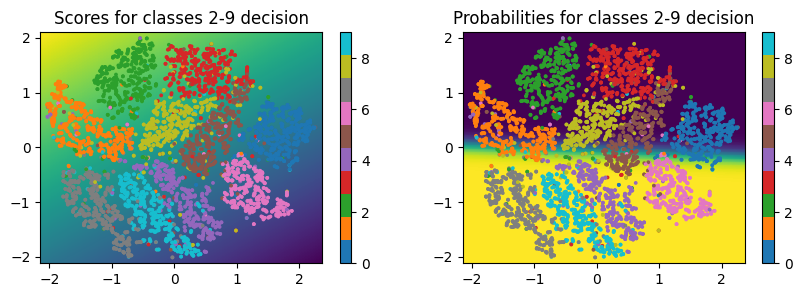

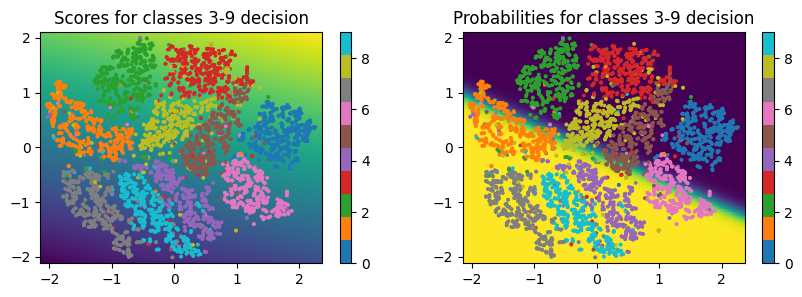

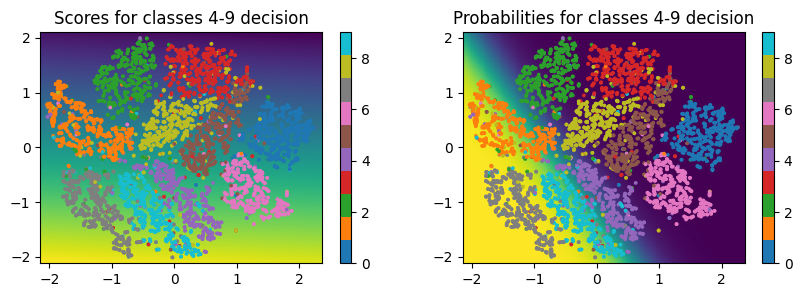

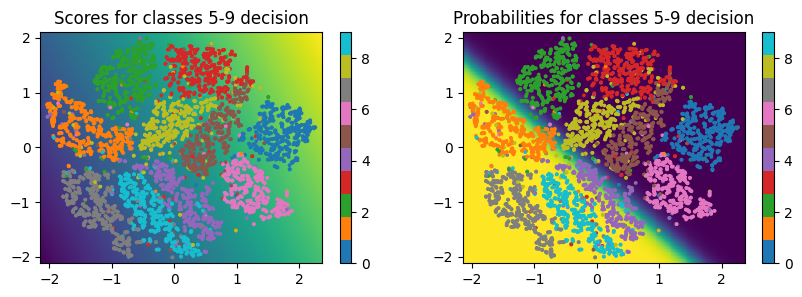

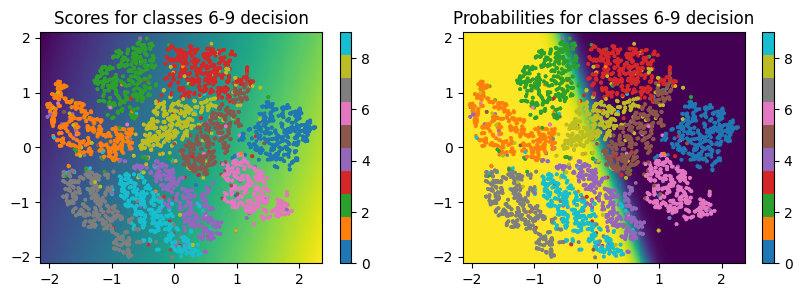

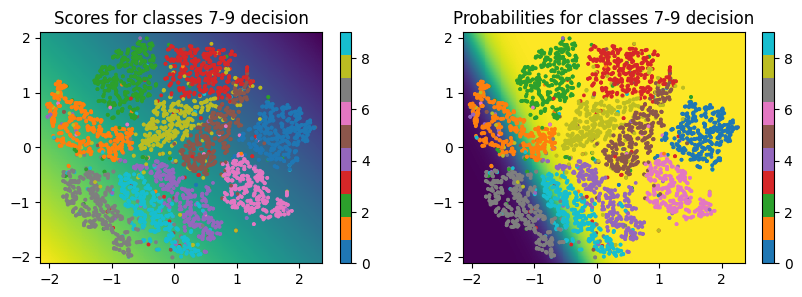

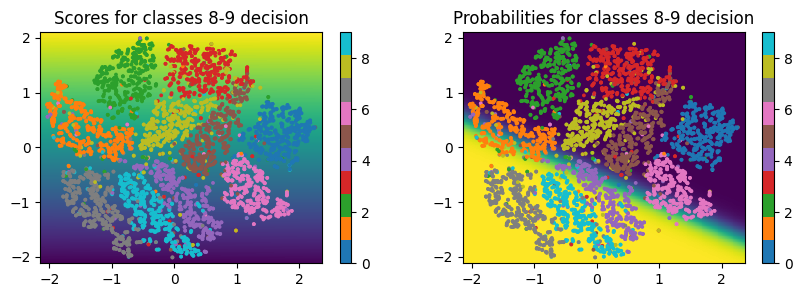

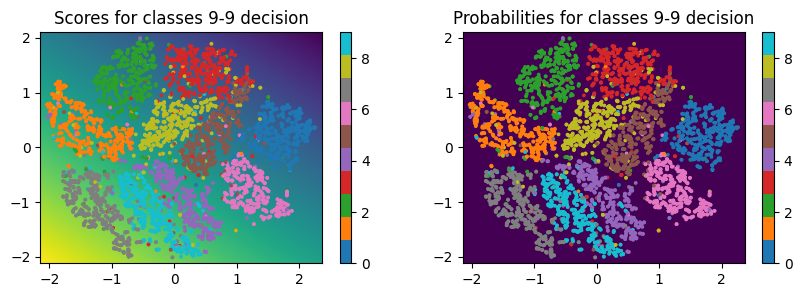

In [10]:
def probs_2_class(data, model, c1, c2):
    """Returns the softmax between two classes."""
    logits = model(data)
    logits = logits[:,[c1, c2]]
    probs = scipy.special.softmax(logits, axis=1)
    return probs[:,0]

def plot_scores_2_class(model, data, labels_train, ref_class):

    for c in range(10):

        scores_c = partial(scores, model=model, c=c)
        probs_c = partial(probs_2_class, model=model, c1=ref_class, c2=c)

        response, xx0, xx1 = viz.create_image(scores_c, data)

        fig, axes = plt.subplots(1, 2, figsize=(10,3))
        co = axes[0].pcolormesh(xx0, xx1, response)
        sc = axes[0].scatter(*data.T, s=3, c=labels_train, cmap='tab10')
        fig.colorbar(sc, ax=axes[0])
        axes[0].set_title(f'Scores for classes {c}-9 decision')

        response, xx0, xx1 = viz.create_image(probs_c, data)

        co = axes[1].pcolormesh(xx0, xx1, response)
        sc = axes[1].scatter(*data.T, s=3, c=labels_train, cmap='tab10')
        fig.colorbar(sc, ax=axes[1])
        axes[1].set_title(f'Probabilities for classes {c}-9 decision')

model = Model(logreg)
plot_scores_2_class(model, proj_tsne, labels_train, ref_class=9)

### Linear separability of the projections

Measure the accuracy of the PCA, t-SNE and UMAP projections

In [12]:
# Original data
logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(data_train, labels_train)
print('Train loss:', cross_entropy(logreg, data_train, labels_train))
print('Train accuracy:', 100*logreg.score(data_train, labels_train))

# PCA projection keeping 95% of the variance
data_train_pca, data_valid_pca = data_util.reduce_dimensionality(data_train, data_valid)
logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(data_train_pca, labels_train)
print('\nTrain loss:', cross_entropy(logreg, data_train_pca, labels_train))
print('Train accuracy:', 100*logreg.score(data_train_pca, labels_train))

logreg = LogisticRegression(C=1000)
logreg.fit(proj_pca, labels_train)
print('\nTrain loss:', cross_entropy(logreg, proj_pca, labels_train))
print('Train Accuracy:', 100*logreg.score(proj_pca, labels_train))

logreg = LogisticRegression(C=1000)
logreg.fit(proj_tsne, labels_train)
print('\nTrain loss:', cross_entropy(logreg, proj_tsne, labels_train))
print('Train Accuracy:', 100*logreg.score(proj_tsne, labels_train))

logreg = LogisticRegression(C=1000)
logreg.fit(proj_umap, labels_train)
print('\nTrain loss:', cross_entropy(logreg, proj_umap, labels_train))
print('Train Accuracy:', 100*logreg.score(proj_umap, labels_train))

Train loss: 0.09306234829133438
Train accuracy: 98.44000000000001

Train loss: 0.2087689054846275
Train accuracy: 94.82000000000001

Train loss: 1.3721356895289507
Train Accuracy: 43.8

Train loss: 0.703837504678786
Train Accuracy: 89.62

Train loss: 0.7516938252100392
Train Accuracy: 88.1
